In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os, shutil
import time, copy

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.CenterCrop(160),
#         transforms.Resize([224,224]),
#         transforms.RandomCrop(160, padding=None, pad_if_needed=True, fill=0, padding_mode='constant'),
        transforms.Resize([224,224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine([-45,45], translate=[0.2,0.2], scale=[0.7,1], shear=15, resample=False, fillcolor=0),
#         transforms.RandomRotation([-90,90], resample=False, expand=False, center=None),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=1, scale=(0.02, 0.05), ratio=(0.3, 3.3), value=0, inplace=False),
        transforms.RandomErasing(p=1, scale=(0.02, 0.05), ratio=(0.3, 3.3), value=0, inplace=False)        
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'LG-orignal-video/view'
data_dir = 'img_hand'
# data_dir = 'LG-orignal-video/images_seperated_full'
image_datasets = {'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']), 
                  'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes, len(class_names))

{'train': 31638, 'val': 2877} 21


In [5]:
len(image_datasets['train'].classes), len(image_datasets['val'].classes)

(21, 21)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, _featuremaps = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # mini batch statistics
                if idx%50==0 and phase=='train':
                    print('[batch loss] {} Loss: {:.4f}'.format(phase, loss.item()))
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm import tqdm_notebook as tqdm

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DynamicGNoise(nn.Module):
    def __init__(self, shape, std=0.2):
        super().__init__()
        self.noise = torch.zeros(shape,shape).cuda()
        self.std   = std
        
    def forward(self, x):
        if not self.training: return x
        self.noise.data.normal_(0, std=self.std)
        return x + self.noise
    
class CAM(nn.Module):
    def __init__(self, n_classes):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(CAM, self).__init__()
        self.scaler = MinMaxScaler()
        self.upsampler =  nn.UpsamplingBilinear2d([224,224])
        self.trans_normal = transforms.Compose([
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

#         ****torch pretrained net****
#         net = models.resnet50(pretrained=True)
#         modules = list(net.children())[:-2]      # delete all untill Conv_5 layer. - 2048
        avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # GAP
        flatten = Flatten()
#         self.backbone = nn.Sequential(*modules) #2048
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),   
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()          
        )
        
        self.class_len = n_classes
        self.classifier = nn.Linear(self.class_len, self.class_len, bias=False) #final linear classifier
        self.noise = DynamicGNoise(224, std=0.05)
        # Freeze resnet
#         for param in self.backbone.parameters():
#             param.requires_grad = False
        
        # 1x1 conv 
        self.conv_final = nn.Sequential(
            nn.Conv2d(256, self.class_len, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(self.class_len, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        )
        # fc layer
        self.fc = nn.Sequential(
            avg_pool,
            flatten,
            self.classifier
        )
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        # CNN backbone
        _images = self.noise(images)
        _conv = self.backbone(_images)
        featuremaps = self.conv_final(_conv)
        # fc layer
        logits = self.fc(featuremaps) 
        return logits, featuremaps
    
        
def getCAM(images_normal):
    """
    get class activation map
    @param images_normal - (N x C x H x W) 
    @return cams_scaled - (N x 224 x 224) [0,1] weight matrix
    @return masks_np - (N x 224 x 224 x C) numpy [0,1] weight matrix
    """
    # forward to model
    logits, featuremaps = model(images_normal) # featuremaps (N x C x H x W)
    preds, indices = logits.softmax(dim=1).sort(dim=1, descending=True) # cam_weight (N x C)
    cam_weights = model.classifier.weight[:,indices[:,0]].transpose(1,0)

    # get class activation map
    cams = []
    for _featuremap, _cam_weight in zip(featuremaps, cam_weights):
        _cam = []
        for c,w in zip(_featuremap, _cam_weight): 
            _cam.append((c*w).data)
        _cam = torch.stack(_cam)
        cams.append(_cam)
    cams = torch.stack(cams)

    cams_updsampled = self.upsampler(cams).sum(dim=1) # batchx224x224
    # scale to [0,1] for recalibrartion weight
    cams_scaled = []
    for _cam_upsampled in cams_updsampled:
        _cam_scaled = model.scaler.fit_transform(_cam_upsampled.cpu().numpy())  
        cams_scaled.append(_cam_scaled)
    cams_scaled = torch.tensor(cams_scaled).data
    masks_np = np.stack([cams_scaled, cams_scaled, cams_scaled], axis=3)
    return cams_scaled, masks_np



In [8]:
from torchsummary import summary
model = CAM(len(image_datasets['train'].classes))
model.to(model.device)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     DynamicGNoise-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 32, 222, 222]             864
       BatchNorm2d-3         [-1, 32, 222, 222]              64
              ReLU-4         [-1, 32, 222, 222]               0
         MaxPool2d-5         [-1, 32, 111, 111]               0
            Conv2d-6         [-1, 64, 109, 109]          18,432
       BatchNorm2d-7         [-1, 64, 109, 109]             128
              ReLU-8         [-1, 64, 109, 109]               0
         MaxPool2d-9           [-1, 64, 54, 54]               0
           Conv2d-10          [-1, 128, 52, 52]          73,728
      BatchNorm2d-11          [-1, 128, 52, 52]             256
             ReLU-12          [-1, 128, 52, 52]               0
        MaxPool2d-13          [-1, 128, 26, 26]               0
           Conv2d-14          [-1, 256,

In [9]:
# model.load_state_dict(torch.load('torch_models/cam-myconv2.pth'))

In [10]:
# """
# for 2nd training
# """
# avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # GAP
# flatten = Flatten()
# cf = nn.Linear(100, 100, bias=False)
# # summary(model, (3, 224, 224))
# model.fc = nn.Sequential(
#     avg_pool, flatten, cf
# )
# model.conv_final = nn.Sequential(
#             nn.Conv2d(256, 100, kernel_size=(1, 1), stride=(1, 1), bias=False),
#             nn.BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#         )
# model.to(model.device)
# summary(model, (3, 224, 224))

In [12]:
classes = image_datasets['train'].classes
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params = list(model.fc.parameters()) + list(model.conv_final.parameters()) + list(model.backbone.parameters())
# optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(params, lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=150)

Epoch 0/149
----------
[batch loss] train Loss: 3.0575
[batch loss] train Loss: 2.9179
[batch loss] train Loss: 2.1480
[batch loss] train Loss: 1.1338
[batch loss] train Loss: 1.1109
[batch loss] train Loss: 0.7047
[batch loss] train Loss: 0.9032
[batch loss] train Loss: 0.5701
[batch loss] train Loss: 0.2793
[batch loss] train Loss: 0.2314
[batch loss] train Loss: 0.2483
[batch loss] train Loss: 0.2540
[batch loss] train Loss: 0.1917
[batch loss] train Loss: 0.6097
[batch loss] train Loss: 0.4877
[batch loss] train Loss: 0.5114
[batch loss] train Loss: 0.2957
[batch loss] train Loss: 0.2388
[batch loss] train Loss: 0.8095
[batch loss] train Loss: 0.3410
train Loss: 0.7814 Acc: 0.8733
val Loss: 0.3782 Acc: 0.9041

Epoch 1/149
----------
[batch loss] train Loss: 0.1617
[batch loss] train Loss: 0.3730
[batch loss] train Loss: 0.3490
[batch loss] train Loss: 0.2698
[batch loss] train Loss: 0.2635
[batch loss] train Loss: 0.1059
[batch loss] train Loss: 0.3035
[batch loss] train Loss: 0.09

[batch loss] train Loss: 0.2035
[batch loss] train Loss: 0.0067
[batch loss] train Loss: 0.0929
[batch loss] train Loss: 0.1423
[batch loss] train Loss: 0.0187
[batch loss] train Loss: 0.3127
[batch loss] train Loss: 0.1504
[batch loss] train Loss: 0.2440
[batch loss] train Loss: 0.4273
[batch loss] train Loss: 0.1465
[batch loss] train Loss: 0.0965
[batch loss] train Loss: 0.3220
[batch loss] train Loss: 0.1276
[batch loss] train Loss: 0.2490
train Loss: 0.1984 Acc: 0.9396
val Loss: 0.2811 Acc: 0.9253

Epoch 12/149
----------
[batch loss] train Loss: 0.0924
[batch loss] train Loss: 0.1739
[batch loss] train Loss: 0.0373
[batch loss] train Loss: 0.1791
[batch loss] train Loss: 0.2597
[batch loss] train Loss: 0.1285
[batch loss] train Loss: 0.0727
[batch loss] train Loss: 0.0822
[batch loss] train Loss: 0.0036
[batch loss] train Loss: 0.1630
[batch loss] train Loss: 0.8571
[batch loss] train Loss: 0.0606
[batch loss] train Loss: 0.1861
[batch loss] train Loss: 0.1390
[batch loss] train 

[batch loss] train Loss: 0.1060
[batch loss] train Loss: 0.3094
[batch loss] train Loss: 0.1226
[batch loss] train Loss: 0.0158
[batch loss] train Loss: 0.1052
[batch loss] train Loss: 0.2954
[batch loss] train Loss: 0.2962
[batch loss] train Loss: 0.1320
train Loss: 0.1649 Acc: 0.9482
val Loss: 0.2340 Acc: 0.9364

Epoch 23/149
----------
[batch loss] train Loss: 0.1853
[batch loss] train Loss: 0.1078
[batch loss] train Loss: 0.1240
[batch loss] train Loss: 0.0202
[batch loss] train Loss: 0.1441
[batch loss] train Loss: 0.2180
[batch loss] train Loss: 0.1469
[batch loss] train Loss: 0.1889
[batch loss] train Loss: 0.3258
[batch loss] train Loss: 0.1188
[batch loss] train Loss: 0.0399
[batch loss] train Loss: 0.3318
[batch loss] train Loss: 0.0387
[batch loss] train Loss: 0.0666
[batch loss] train Loss: 0.2794
[batch loss] train Loss: 0.1450
[batch loss] train Loss: 0.2112
[batch loss] train Loss: 0.2796
[batch loss] train Loss: 0.1435
[batch loss] train Loss: 0.1326
train Loss: 0.1647 

[batch loss] train Loss: 0.1323
[batch loss] train Loss: 0.0053
train Loss: 0.1442 Acc: 0.9540
val Loss: 0.2584 Acc: 0.9350

Epoch 34/149
----------
[batch loss] train Loss: 0.0401
[batch loss] train Loss: 0.1675
[batch loss] train Loss: 0.0234
[batch loss] train Loss: 0.0187
[batch loss] train Loss: 0.4702
[batch loss] train Loss: 0.0444
[batch loss] train Loss: 0.1826
[batch loss] train Loss: 0.2453
[batch loss] train Loss: 0.0238
[batch loss] train Loss: 0.1927
[batch loss] train Loss: 0.0288
[batch loss] train Loss: 0.1429
[batch loss] train Loss: 0.0685
[batch loss] train Loss: 0.2936
[batch loss] train Loss: 0.3461
[batch loss] train Loss: 0.2830
[batch loss] train Loss: 0.1656
[batch loss] train Loss: 0.0107
[batch loss] train Loss: 0.0032
[batch loss] train Loss: 0.0133
train Loss: 0.1432 Acc: 0.9550
val Loss: 0.2621 Acc: 0.9374

Epoch 35/149
----------
[batch loss] train Loss: 0.1525
[batch loss] train Loss: 0.0750
[batch loss] train Loss: 0.0687
[batch loss] train Loss: 0.180

In [14]:

# class_correct = list(0. for i in range(len(classes)))
# class_total = list(0. for i in range(len(classes)))
# model.eval()
# for data in dataloaders['val']:
#     images, labels = data[0].to(device), data[1].to(device)
#     outputs, _featuremaps = model(images)
#     _, predicted = torch.max(outputs, 1)
#     c = (predicted == labels).squeeze()
#     for i in range(len(labels)):
#         label = labels[i]
#         class_correct[label] += c[i].item()
#         class_total[label] += 1


# for i in range(len(classes)):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))

In [197]:
torch.save(model.state_dict(), 'torch_models/cam-myconv-21.pth')

___
# VISUALIZE

In [179]:
cam_dataset = torchvision.datasets.ImageFolder(
#     root='new-cosmetic-frontview/images_ext',
#     root='LG-orignal-video/images_seperated_full/backbone',
    root='LG-orignal-video/images_seperated_full/train',
#     root='server/vu-visor/static/images_ext_bak',
#     root='img_real/server',
    transform=transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
#         transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
#         transforms.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
trans_normal = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# cam_dataset = image_datasets['train']
cam_loader = torch.utils.data.DataLoader(cam_dataset, batch_size=3,
                                          shuffle=True, num_workers=4)

def show_img(imgPath):
    frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
    # opencv frme input // H*W*C(BGR)
    # 0-255 3 channel
    inputs = torch.Tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))/255 # 여기 Tensor 소문자로 바꾸면 안됨... 차이 알아보기
    plt.imshow(inputs)
    plt.show()

def show_tensor(t):
    plt.imshow(t.numpy().transpose([1,2,0]))
    plt.show()

In [180]:
model.eval()
cam_iter = iter(cam_loader)

In [181]:
def getCAM(images_normal):
    """
    get class activation map
    @param images_normal - (N x C x H x W) 
    @return cams_scaled - (N x 224 x 224) [0,1] weight matrix
    @return masks_np - (N x 224 x 224 x C) numpy [0,1] weight matrix
    """
    # forward to model
    logits, featuremaps = model(images_normal) # featuremaps (N x C x H x W)
    preds, indices = logits.softmax(dim=1).sort(dim=1, descending=True) # cam_weight (N x C)
    cam_weights = model.classifier.weight[:,[10]*len(indices)].transpose(1,0)
#     cam_weights = model.classifier.weight[:,indices[:,0]].transpose(1,0)
    print(indices[:,0], len(indices))

    # get class activation map
    cams = []
    for _featuremap, _cam_weight in zip(featuremaps, cam_weights):
        _cam = []
        for c,w in zip(_featuremap, _cam_weight): 
            _cam.append((c*w).data)
        _cam = torch.stack(_cam)
        cams.append(_cam)
    cams = torch.stack(cams)

    cams_updsampled = model.upsampler(cams).sum(dim=1) # batchx224x224
    # scale to [0,1] for recalibrartion weight
    cams_scaled = []
    for _cam_upsampled in cams_updsampled:
        _cam_scaled = model.scaler.fit_transform(_cam_upsampled.cpu().numpy())  
        cams_scaled.append(_cam_scaled)
    cams_scaled = torch.tensor(cams_scaled).data
    masks_np = np.stack([cams_scaled, cams_scaled, cams_scaled], axis=3)
    return cams_scaled, masks_np

tensor([13,  9,  9], device='cuda:0') 3
Wall time: 35 ms


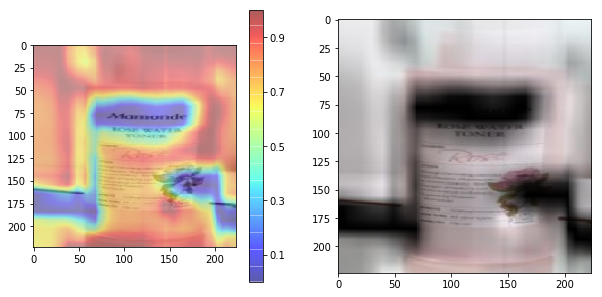

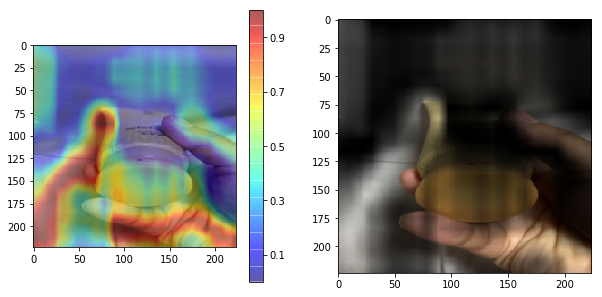

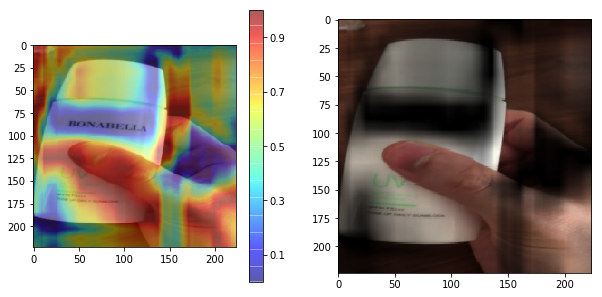

In [196]:
images, labels = next(cam_iter)
images = images.data.to(model.device)
images_normal = []
for image in images:
    images_normal.append(trans_normal(image))
images_normal = torch.stack(images_normal)

# get class activation map
%time cams_scaled, masks_np = getCAM(images_normal)

for image, cam_scaled, mask in zip(images, cams_scaled, masks_np):
    # plot
    im_np = image.cpu().numpy().transpose([1,2,0]).clip(0,1)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(im_np)
    # plt.imshow(cam_scaled.clip(0, .2), cmap='jet', alpha=0.4)
    plt.imshow(cam_scaled, cmap='jet', alpha=0.4)
    plt.colorbar(ticks=[0.1,0.3,0.5,0.7,0.9], orientation ='vertical')

    # img masked
    im_masked = im_np*mask
    plt.subplot(122)
    plt.imshow(im_masked.clip(0,1))
    plt.show()